<a href="https://colab.research.google.com/github/CompPsychology/psych290_colab_public/blob/main/notebooks/week-07/W7_Tutorial_11_DLATK_modeling_LDA_topics_(dla_tutorial%2Csvitlana).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# W7 Tutorial 11 -- Modeling your own topics with DLATK (DB: dla_tutorial) (2025-02)

✋🏻✋🏻 NOTE - You need to create a copy of this notebook before you work through it. Click on "Save a copy in Drive" option in the File menu, and safe it to your Google Drive.

✉️🐞 If you find a bug/something doesn't work, please slack us a screenshot, or email johannes.courses@gmail.com.

(c) Johannes Eichstaedt & the World Well-Being Project, 2023.

... and MALLET in the background.

Mallet creates the cleanest topics that we know of, and and it's original version runs much faster than Python implmementations. DLATK internally uses Mallet to model topics from a text corpus. This is a step by step walk through of how to do model topics from scratch using DLATK.

Step 1 is to have data. Topics are modeled on message tables, at the message level. We'll stick with `dla_tutorial` data to start.

<h2> Introduction

This tutorial shows how to use Mallet to train a topic model and get the results into SQLite tables (or 🐬 MySQL if not in Colab!) so that DLATK can extract them from your text, and correlate them, and visualize them, and so forth.

As usual, let's set up Colab, Google Drive, and the SQLite connection. 😅

🚨🚨 When you run section 1a, it will ask you if you want to Restart the session. **Please do restart the session**! (Can also do Runtime ==> Restart session.) We are working out some dependency issues in the code, but for now this works 😎

## 1) Setting up Colab with DLATK and SQLite

### 1a) Install DLATK

☝🏻 Don't forget to click `Restart` if it prompts you to!

In [ ]:
# installing DLATK and necessary packages
!git clone -b psych290 https://github.com/dlatk/dlatk.git
!pip install -r dlatk/install/requirements.txt
!pip install dlatk/
!pip install wordcloud langid jupysql gensim==4.3

### 1b) Mount Google Drive and copy databases

In [ ]:
database = "dla_tutorial"

In [ ]:
# Mount Google Drive & copy to Colab

# connects & mounts your Google Drive to this colab space
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# this copies dlatk_lexica.db from your Google Drive to Colab
!cp -f "/content/drive/MyDrive/sqlite_databases/dlatk_lexica.db" "sqlite_data"

# this copies {database}.db from your Google Drive to Colab
!cp -f "/content/drive/MyDrive/sqlite_databases/{database}.db" "sqlite_data"

Mounted at /content/drive


### 1c) Setup database connection

In [ ]:
# loads the %%sql extension
%load_ext sql

# connects the extension to the database - mounts both databases as engines
from sqlalchemy import create_engine
tutorial_db_engine = create_engine(f"sqlite:///sqlite_data/{database}.db?charset=utf8mb4")
dlatk_lexica_engine = create_engine(f"sqlite:///sqlite_data/dlatk_lexica.db?charset=utf8mb4")

# attaches the dlatk_lexica.db so tutorial_db_engine can query both databases
from IPython import get_ipython
from sqlalchemy import event

# auto‑attach the lexica db whenever tutorial_db_engine connects
@event.listens_for(tutorial_db_engine, "connect")
def _attach_lexica(dbapi_conn, connection_record):
    dbapi_conn.execute("ATTACH DATABASE 'sqlite_data/dlatk_lexica.db' AS dlatk_lexica;")

%sql tutorial_db_engine

#set the output limit to 50
%config SqlMagic.displaylimit = 50

### 1d) (ONLY If nedded: SOFT RELOAD): If you have a **"database lock"** problem

If you face a "database locked" issue:
  1. restart the session (Runtime ==> Restart Session)
  2. run this cell to get set back up!


This block is your friend! ☺️ If you are working with other databases and you get a db locked error, (1) restart the session and (2) run the cell below, changing the database variable to your database name. For example, if you're working with blog_authorship.db, do `datatbase="blog_authorship"`!

In [ ]:
database = "dla_tutorial"

%reload_ext sql

from sqlalchemy import create_engine
tutorial_db_engine = create_engine(f"sqlite:///sqlite_data/{database}.db?charset=utf8mb4")
dlatk_lexica_engine = create_engine(f"sqlite:///sqlite_data/dlatk_lexica.db?charset=utf8mb4")

# set the output limit to 50
%config SqlMagic.displaylimit = 50

from IPython import get_ipython
from sqlalchemy import event

# auto‑attach the lexica db whenever tutorial_db_engine connects
@event.listens_for(tutorial_db_engine, "connect")
def _attach_lexica(dbapi_conn, connection_record):
    dbapi_conn.execute("ATTACH DATABASE 'sqlite_data/dlatk_lexica.db' AS dlatk_lexica;")

%sql tutorial_db_engine

## 2) Extract 1 grams

DLATK needs 1-gram feature table to train the topic model. So, the first step would be to extract the 1-gram features.

**Note that we need to extract 1grams at the message level, and set group-freq-thresh to 0 (to include all documents).**

Message-level feature extractions always take longer than for users. 6 minutes.

**Note**: it often makes sense to break longer "documents" (say paragraphs, or pages, or abstracts) into sentences for topic modeling. Refer to **Tutorial 07 for sentence tokenization** (`--add_sent_per_row`) (turn messages = longer documents into messages = sentences).

In [ ]:
database = 'dla_tutorial'
msgs_table = 'msgs'

In [ ]:
!dlatkInterface.py \
    --corpdb {database} \
    --corptable {msgs_table} \
    --correl_field message_id \
    --group_freq_thresh 0 \
    --add_ngrams -n 1

The above command produced table `feat$1gram$msgs$message_id`.

In [ ]:
feat_1gram_message = 'feat$1gram$msgs$message_id'

In [ ]:
%%sql

SELECT *
FROM {{feat_1gram_message}}
ORDER BY RANDOM()
LIMIT 5;

There are many words in this feat table that are **very common** among all users (what are called "stop words" or "function words"). For our topic modeling to be effective, we should remove highly frequent words. But the number of words we remove depends on our dataset and our use case. You may want to be more or less aggressive. `100` is often a good choice.

You might want to look at the first 150 1grams by frequency to confirm that dropping the first 100 is what you want -- sometimes words occur earlier in the list that are still of great interest to you, depending on the dataset. Sometimes very frequent function words show up beyond 100.  Throwing out the top 50-150 or so can all be reasonable depending your dataset.

As a good first pass, do 100 but, let's look at the 200 most frequent, with some SQL extra credit stuff to give us row numbers.

In [ ]:
feat_1gram_message = 'feat$1gram$msgs$message_id'
N = 200

Let's set the `%sql` output limit to 200 (so we can see all 200 tokens)!

In [ ]:
# set the output limit to 200
%config SqlMagic.displaylimit = 200

In [ ]:
%%sql

SELECT ROW_NUMBER() OVER (ORDER BY n_occ DESC) AS n, feat, n_occ
FROM (SELECT feat, SUM(value) AS n_occ
      FROM {{feat_1gram_message}}
      GROUP BY feat
      ORDER BY n_occ DESC
      LIMIT {{N}}) AS a;

Wow!

FYI: this is how the command looks in MySQL.

```
🐬🐬🐬
SET @n = 0;
SELECT @n := @n + 1 n, a.*
FROM (SELECT feat, SUM(value) AS n_occ
      FROM {{feat_1gram_user}}
      GROUP BY feat
      ORDER BY n_occ DESC
      LIMIT {{N}}) AS a;
🐬🐬🐬
```

In [ ]:
#set the output limit back to 50 :)
%config SqlMagic.displaylimit = 50

## 3) Modeling topics

From the list above, we can see that most of the top-100 words are stop words, so function words more than content words. So let's remove them when we model the topics below. (One could be more exclusive: word 126 is still a pronoun. One could exclude more.)

The topic modeling is done in one DLATK command around the flag `--estimate_lda_topics`.

To avoid chaos, we are storing the topic tables you create in your own databases (rather than in the central `dlatk_lexica` for which you only have read permission). We adjust this through setting `--lexicondb` to your 'dla_tutorial' database as well.

Before we continue, let's see what the new parameters mean.

* `--estimate_lda_topics` - As the parameter says, this is the most important flag in this command which tells DLATK to model new topics using the feature table.

* `--num_stopwords` - Specifies the number of stopwords (50-150 are sensible. Here let's pick 100).
* `--num_topics` - Specifies the number of topics to be extracted (you need 50-100 documents per topic. dla_tutorial has 30k messages = 300-600 topics would be possible, at a maximum).
* `--lda_alpha` - This parameter is used to set parameter of how many topics you expect per document (5 is a good default. Values from 2-5 or so seem sensible. The longer the document, the larger we want to make this number. For something that's as long as a sentence, like a tweet, 2 is a good number. Colleagues report "leaving it at 5 for anything but Tweets works well").
* `--lexicondb` - Database where the topic tables should be stored (for simplicity, same database as your msgs and feature tables).
* `--lda_lexicon_name` - If we set the lexicon name as `NAME` we get topic tables as `NAME_cp` and `NAME_freq` in the end.
* `--mallet_path` - This is needed to specify the path to Mallet which implements Topic Modeling inside DLATK. You need not change this, this is just some under-the-hood stuff.

Most of the parameters are based on experience and rules of thumb. This makes topic modeling an iterative process in which you may repeat the modeling with different parameter settings and observe if the topics gets "cleaner" -- more semantically coherent, with fewer intrusion words.

Let's drop 100 stop words, model 100 topics, and set the alpha (topics per document) to 5.

🚨🚨 The DLATK command below *may* give you a "database locked" error. If that does happen, (1) restart (Runtime ==> Restart session), (2) run cell 1d, then (3) run the cells below again!

We're working on this! 🙏

In [ ]:
num_stopwords = 100
num_topics = 100
alpha = 5
lexicon_database = 'dla_tutorial'

# name your topics something meaningful -- good to encode: source, number, alpha, stopwords
# the f means it's an f-string (can format variables into a string)
lexicon_name = f'dlat_{num_topics}_a{alpha}s{num_stopwords}'

database = 'dla_tutorial'
msgs_table = 'msgs'
feat_1gram_message = 'feat$1gram$msgs$message_id'

OUTPUT_FOLDER = './output_tutorial_11/dla_tutorial'
!mkdir -p {OUTPUT_FOLDER}

This command may take a long time (~20 minutes), and show you updated topics as it goes along. The LL in there is "log likelikhood" -- a measure of model fit.

In [ ]:
!dlatkInterface.py \
    --corpdb {database} \
    --corptable {msgs_table} \
    --correl_field message_id \
    --feat_table '{feat_1gram_message}' \
    --estimate_lda_topics \
    --num_stopwords {num_stopwords} \
    --num_topics {num_topics} \
    --lda_alpha {alpha} \
    --lexicondb {lexicon_database} \
    --save_lda_files {OUTPUT_FOLDER} \
    --lda_lexicon_name {lexicon_name} \
    --mallet_path /opt/mallet/bin/mallet

## 4) Explore the generated topics

Now, let's explore the topic tables generated (this is a bit of a repeat from Tutorial 10 -- but for your very own topics). We know that the above command creates -
   
- **Conditional Probablity table** - for a given word encountered in a 1gram, we get the mapping of that word to topics  ($P(topic | word)$) -  `dlat_100_a5s100_cp` in this case.

- **Frequency table** - for a given topic, which words most constitute it ($F(word | topic)$) - `dlat_100_a5s100_t50ll` here.

Let's find the topic tables:

In [ ]:
result = %sqlcmd tables
print(result)

### 4a) Conditional Probability table

Let's see what's in the conditional probability table. How about we find the $P(topic|word)$ for the word `software`?

In [ ]:
topics_cp_table = 'dlat_100_a5s100_cp'

In [ ]:
%%sql

SELECT *
FROM {{topics_cp_table}}
WHERE term = "software"
ORDER BY weight DESC
LIMIT 10;

Running query in 'sqlite:///sqlite_data/dla_tutorial.db?charset=utf8mb4'

id,term,category,weight
21333,software,6,0.5981012658227849
74285,software,24,0.2658227848101266
124839,software,42,0.09177215189873418
58951,software,19,0.04430379746835443


So, these are the topics that a single occurrence of "software" gets mapped to. Importantly, for a given word, they sum to one. Let's confirm that.

In [ ]:
topics_cp_table = 'dlat_100_a5s100_cp'

In [ ]:
%%sql

SELECT SUM(weight)
FROM {{topics_cp_table}}
WHERE term = "software" ;

Running query in 'sqlite:///sqlite_data/dla_tutorial.db?charset=utf8mb4'

SUM(weight)
1.0000000000000002


In the world of the topic tables, this is **the only thing** that sums to one / is normalized.

### 4b) Frequency table

Now, we explore the frequency table by checking what topic `11` made of (random choice). Modeled topics change randomly on every run of Mallet! (different random seed). We can't predict what will be in your topic 11.

In [ ]:
topics_freq_table = 'dlat_100_a5s100_freq_t50ll'

In [ ]:
%%sql

SELECT *
FROM {{topics_freq_table}}
WHERE category = "11"
ORDER BY weight DESC
LIMIT 10;

Running query in 'sqlite:///sqlite_data/dla_tutorial.db?charset=utf8mb4'

id,term,category,weight
25479,he's,11,1413.0
25480,she's,11,1019.0
25481,friends,11,477.0
25482,friend,11,465.0
25483,talk,11,353.0
25484,guy,11,344.0
25485,we're,11,254.0
25486,they're,11,220.0
25487,talked,11,210.0
25488,met,11,189.0


Yay! Seems fairly coherent (we hope)

### Top words for given topics

Now, let's check what are the top words are for some random topics using GROUP_CONCAT in SQL.

In [ ]:
topics_freq_table = 'dlat_100_a5s100_freq_t50ll'

In [ ]:
%%sql

SELECT category, GROUP_CONCAT(term, ', ') AS top_words
FROM (
  SELECT category, term
  FROM (SELECT category, term, weight, ROW_NUMBER() OVER (PARTITION BY category ORDER BY weight DESC) AS rn FROM {{topics_freq_table}}) AS ranked
  WHERE rn <= 10
  ORDER BY category, weight DESC) AS top_10_words_ordered
GROUP BY category
HAVING category LIKE '11' OR category LIKE '95' OR category LIKE '99';

Running query in 'sqlite:///sqlite_data/dla_tutorial.db?charset=utf8mb4'

category,top_words
11,"he's, she's, friends, friend, talk, guy, we're, they're, talked, met"
95,"tree, animals, fire, bird, trees, birds, dead, spaceypixiechick, animal, garden"
99,"music, mass, hymn, thomas, sing, choir, singing, piano, theatre, communion"


```
🐬🐬🐬
SET @num := 0, @type := '';
        
SELECT category, GROUP_CONCAT(term ORDER BY weight DESC SEPARATOR ', ') AS top_words
FROM (SELECT category, term, weight, @num := IF(@type = category, @num + 1, 1) AS row_number, @type := category AS dummy
      FROM {topics_freq_table}
      ORDER BY category, weight DESC) AS x
WHERE x.row_number <= 10
GROUP BY category
HAVING category LIKE "11" OR category LIKE "95"  OR category LIKE "99";
🐬🐬🐬
```

### 4c) Top words for topics containing a keyword

In [ ]:
topics_freq_table = 'dlat_100_a5s100_freq_t50ll'

In [ ]:
%%sql

SELECT category, GROUP_CONCAT(term, ', ') AS top_words
FROM (
  SELECT category, term
  FROM (SELECT category, term, weight, ROW_NUMBER() OVER (PARTITION BY category ORDER BY weight DESC) AS rn FROM {{topics_freq_table}}) AS ranked
  WHERE rn <= 10
  ORDER BY category, weight DESC) AS top_10_words_ordered
GROUP BY category
HAVING top_words LIKE '%party%';

Running query in 'sqlite:///sqlite_data/dla_tutorial.db?charset=utf8mb4'

category,top_words
22,"bush, kerry, president, vote, party, john, political, election, republican, campaign"
4,"night, bar, drink, party, beer, weekend, dinner, drinking, evening, saturday"
96,"birthday, happy, christmas, party, celebrate, cake, holiday, gift, indy, dinner"


```
🐬🐬🐬
SET @num := 0, @type := '';
SELECT category, GROUP_CONCAT(term ORDER BY weight DESC SEPARATOR ', ') AS top_words
FROM (SELECT category, term, weight, @num := IF(@type = category, @num + 1, 1) AS row_number, @type := category AS dummy
      FROM {topics_freq_table}
      ORDER BY category, weight DESC) AS x
WHERE x.row_number <= 10
GROUP BY category
HAVING top_words LIKE "%party%";
🐬🐬🐬
```

<h1> ⚠️

Because we have written the topics to your database, all commands below must be told to look for the topic tables in your 'dla_tutorial' database, and not in the default `dlatk_lexica`.

We adjust this in all commands by setting the flag `--lexicondb {lexicon_database}`.

## 5) Topic wordclouds

Now, let's produce topic wordclouds (like how we did with 1-grams, LIWC features, etc.) using DLATK, rather than as a list of words above. This will take a few minutes as it goes over all topics we've modeled.

In [ ]:
database ='dla_tutorial'
msgs_table = 'msgs'

lexicon_database = 'dla_tutorial'
OUTPUT_FOLDER = './output_tutorial_11'
OUTPUT_NAME = 'dlat_topic_wordclouds'
topics_freq_table = 'dlat_100_a5s100_freq_t50ll'


!mkdir -p {OUTPUT_FOLDER}

In [ ]:
!dlatkInterface.py \
    --corpdb {database} \
    --corptable {msgs_table} \
    --topic_lexicon {topics_freq_table} \
    --lexicondb {lexicon_database} \
    --group_freq_thresh 500 \
    --make_all_topic_wordclouds \
    --tagcloud_colorscheme blue \
    --output {OUTPUT_FOLDER}/{OUTPUT_NAME}

The above command wrote wordcloud png files into `./output_tutorial_11/dlat_topic_wordclouds_alltopics` directory. Let's just look at 5 of them.

In [ ]:
!ls -lht {OUTPUT_FOLDER}/{OUTPUT_NAME}_alltopics | head -n 5

total 6.2M
-rw-r--r-- 1 root root 62K May 16 21:06 topic_99_wc.png
-rw-r--r-- 1 root root 64K May 16 21:06 topic_98_wc.png
-rw-r--r-- 1 root root 66K May 16 21:06 topic_97_wc.png
-rw-r--r-- 1 root root 63K May 16 21:06 topic_96_wc.png


Let's plot some of the wordclouds using the `print_topic_wordclouds` below.

In [ ]:
import glob
import os
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def print_topic_wordclouds(wordcloud_folder, num_topics):

    image_list = glob.glob(os.path.join(wordcloud_folder, '*.png'))[:num_topics]
    images_per_row = 4

    fig, axes = plt.subplots(math.ceil(num_topics/images_per_row), images_per_row, figsize=(18, 8))
    for index, image in enumerate(image_list):

        axes[int(index/images_per_row), index%images_per_row].set_axis_off()
        axes[int(index/images_per_row), index%images_per_row].set_title(image.split('/')[-1])
        axes[int(index/images_per_row), index%images_per_row].imshow(mpimg.imread(image))

    return

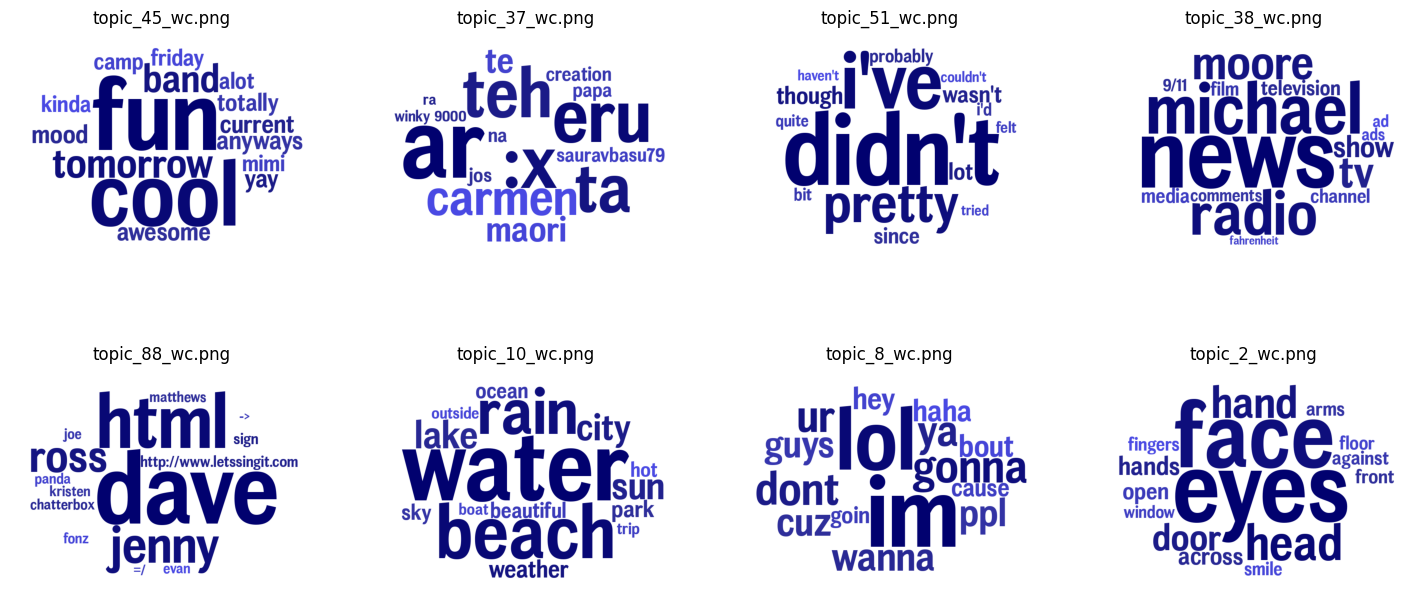

In [ ]:
WORDCLOUD_FOLDER = './output_tutorial_11/dlat_topic_wordclouds_alltopics/'
NUM_TOPICS = 8

print_topic_wordclouds(WORDCLOUD_FOLDER, NUM_TOPICS)

Congratulations, you've modeled your own state-of-the-art LDA topics using DLATK!!

<h1> ⚠️

**One final note:** note that we have written these topics to your own database, rather than `dlatk_lexica`. If you want to reference them from `--correlate` or `--add_lex_table` commands going forward, you will have to tell DLATK to look for these tables in your DB: with `--lexicondb dla_tutorial`.

## 6) Delete topics

Normally, you end up fiddling with the settings a little, and would try different numbers of topics.

For completeness, let's end this by removing the topic tables we created. The commands have been commented because we don't want to run them by mistake (after all the hard work above!!)

In [ ]:
lexicon_database = 'dla_tutorial'
topics_cp_table = 'dlat_100_a5s100_cp'
topics_freq_table = 'dlat_100_a5s100_freq_t50ll'

In [ ]:
# %%sql

# DROP TABLE IF EXISTS {{topics_cp_table}};
# DROP TABLE IF EXISTS {{topics_freq_table}};

## 7) Topic modeling on annotated messages: `svitlana` database

Here we will use the Annotated Emotion dataset [Svitlana Volkova](https://www.cs.jhu.edu/~svitlana/), which is in the `svitlana` database. It contains ~29k Tweets annotated with emotions. Here, the documents = tweets are directly annotated with one of a few emotions. We have also added the `outcomes` table, that has the emotions listed for a given `message_id`.

Citation for the dataset -
```
Volkova, S., & Bachrach, Y. (2016, August). Inferring perceived demographics from user emotional tone and user-environment emotional contrast. In Proceedings of the 54th Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers) (pp. 1567-1578).
```

Let's model topics across these tweets -- we'll begin with setup, then message-level (tweet-level) 1-gram extraction.

In [ ]:
# name of database
database = 'svitlana'

In [ ]:
# Mount Google Drive & copy to Colab

# connects & mounts your Google Drive to this colab space
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# this copies {database}.db from your Google Drive to Colab
!cp -f "/content/drive/MyDrive/sqlite_databases/{database}.db" "sqlite_data"

Mounted at /content/drive


The usual SQLite database connection procedure!

In [ ]:
# reloads the %%sql extension
%reload_ext sql

# connects the extension to the database - mounts the database as an engine
from sqlalchemy import create_engine
svitlana_engine = create_engine(f"sqlite:///sqlite_data/{database}.db?charset=utf8mb4")

# use engine (activates the connection to new database!!)
%sql svitlana_engine

#set the output limit to 50
%config SqlMagic.displaylimit = 50

☝🏻 **FYI**: if you face the **database locked** while using this database, Restart your session (Runtime ==> Restart session), then run the last 3 cells again!

1-gram message level extraction!

In [ ]:
database = 'svitlana'
msgs_table = 'svitlana_msgs'

In [ ]:
!dlatkInterface.py \
    --corpdb {database} \
    --corptable {msgs_table} \
    --correl_field message_id \
    --group_freq_thresh 0 \
    --add_ngrams -n 1




-----
DLATK Interface Initiated: 2025-05-16 02:46:19
-----
Connecting to SQLite database: /content/sqlite_data/svitlana
query: PRAGMA table_info(svitlana_msgs)
SQL Query: DROP TABLE IF EXISTS feat$1gram$svitlana_msgs$message_id
SQL Query: CREATE TABLE feat$1gram$svitlana_msgs$message_id ( id INTEGER PRIMARY KEY, group_id INTEGER, feat VARCHAR(36), value INTEGER, group_norm DOUBLE)


Creating index correl_field on table:feat$1gram$svitlana_msgs$message_id, column:group_id 


SQL Query: CREATE INDEX correl_field$1gram$svitlana_msgs$message_id ON feat$1gram$svitlana_msgs$message_id (group_id)


Creating index feature on table:feat$1gram$svitlana_msgs$message_id, column:feat 


SQL Query: CREATE INDEX feature$1gram$svitlana_msgs$message_id ON feat$1gram$svitlana_msgs$message_id (feat)
query: PRAGMA table_info(svitlana_msgs)
SQL Query: DROP TABLE IF EXISTS feat$meta_1gram$svitlana_msgs$message_id
SQL Query: CREATE TABLE feat$meta_1gram$svitlana_msgs$message_id ( id INTEGER PRIMARY KEY, g

Now let's look at the most frequent words so that we can decide on the number of stopwords.

In [ ]:
# let's find the 1gram message feature table
%sqlcmd tables

In [ ]:
database = 'svitlana'
feat_1gram_message = 'feat$1gram$svitlana_msgs$message_id'
N = 200

In [ ]:
#set the output limit to 200
%config SqlMagic.displaylimit = 200

Now, the special SQL query to get the most frequent tokens!

In [ ]:
%%sql

SELECT ROW_NUMBER() OVER (ORDER BY n_occ DESC) AS n, a.*
FROM (SELECT feat, SUM(value) AS n_occ
      FROM {{feat_1gram_message}}
      GROUP BY feat
      ORDER BY n_occ DESC
      LIMIT {{N}}) AS a;

Running query in 'sqlite:///sqlite_data/svitlana.db?charset=utf8mb4'

n,feat,n_occ
1,the,15003
2,.,14234
3,i,12308
4,to,11603
5,a,9641
6,!,9475
7,and,8081
8,",",7228
9,#disgusting,6787
10,my,6745


In [ ]:
#set the output limit back to 50 :)
%config SqlMagic.displaylimit = 50

Based on the above list, let's decide on `120`, because "u" is definitely a pronoun. Then, we model the topics (`200` in this case) using the DLATK command below.

In [ ]:
database = "svitlana"

num_topics = 200
num_stopwords = 120
alpha = 5

lexicon_database = "svitlana"
lexicon_name = f'svitlana_{num_topics}_a{alpha}s{num_stopwords}' # 200 topics, alpha = 5, 120 stopwords

msgs_table = 'svitlana_msgs'
feat_1gram_message = 'feat$1gram$svitlana_msgs$message_id'

OUTPUT_FOLDER = './output_tutorial_11/svitlana'
!mkdir -p {OUTPUT_FOLDER}

In [ ]:
!dlatkInterface.py \
    --corpdb {database} \
    --corptable {msgs_table} \
    --correl_field message_id \
    --feat_table '{feat_1gram_message}' \
    --estimate_lda_topics \
    --num_stopwords {num_stopwords} \
    --num_topics {num_topics} \
    --lda_alpha {alpha} \
    --lexicondb {lexicon_database} \
    --save_lda_files {OUTPUT_FOLDER} \
    --lda_lexicon_name {lexicon_name} \
    --mallet_path /opt/mallet/bin/mallet

Let's check the created tables.

In [ ]:
result = %sqlcmd tables
print(result)

Mallet decides on these conventions for naming the two tables `_cp` is conditional probabilty, and the `_freq_t50ll` is the frequency table. You could rename them if you wish!

#### 👩‍🔬💻 Exercise

As an exercise, find the top words for topics containing `chicken` as the keyword. Feel free to copy the query above.

**Answer:**

And finally, we produce the wordclouds of all the topics, if we want them.

In [ ]:
OUTPUT_FOLDER = './output_tutorial_11'
OUTPUT_NAME = 'svitlana_topic_wordclouds'
lexicon_database = "svitlana"
topics_freq_table = 'svitlana_200_a5s120_freq_t50ll'

!mkdir -p {OUTPUT_FOLDER}

In [ ]:
!dlatkInterface.py \
    --corpdb {database} \
    --corptable {msgs_table} \
    --topic_lexicon {topics_freq_table} \
    --lexicondb {lexicon_database} \
    --group_freq_thresh 500 \
    --make_all_topic_wordclouds \
    --tagcloud_colorscheme blue \
    --output {OUTPUT_FOLDER}/{OUTPUT_NAME}




-----
DLATK Interface Initiated: 2025-05-16 21:28:33
-----
Connecting to SQLite database: /content/sqlite_data/svitlana
Generating wordclouds using amueller's python package...
Wordcloud created at: ./output_tutorial_11/svitlana_topic_wordclouds_alltopics/topic_0_wc.png
Generating wordclouds using amueller's python package...
Wordcloud created at: ./output_tutorial_11/svitlana_topic_wordclouds_alltopics/topic_1_wc.png
Generating wordclouds using amueller's python package...
Wordcloud created at: ./output_tutorial_11/svitlana_topic_wordclouds_alltopics/topic_10_wc.png
Generating wordclouds using amueller's python package...
Wordcloud created at: ./output_tutorial_11/svitlana_topic_wordclouds_alltopics/topic_100_wc.png
Generating wordclouds using amueller's python package...
Wordcloud created at: ./output_tutorial_11/svitlana_topic_wordclouds_alltopics/topic_101_wc.png
Generating wordclouds using amueller's python package...
Wordcloud created at: ./output_tutorial_11/svitlana_topic_wo

The wordclouds will be stored in `./output_tutorial_11/svitlana_topic_wordclouds_alltopics/` folder. Let's plot some of them to complete this section.

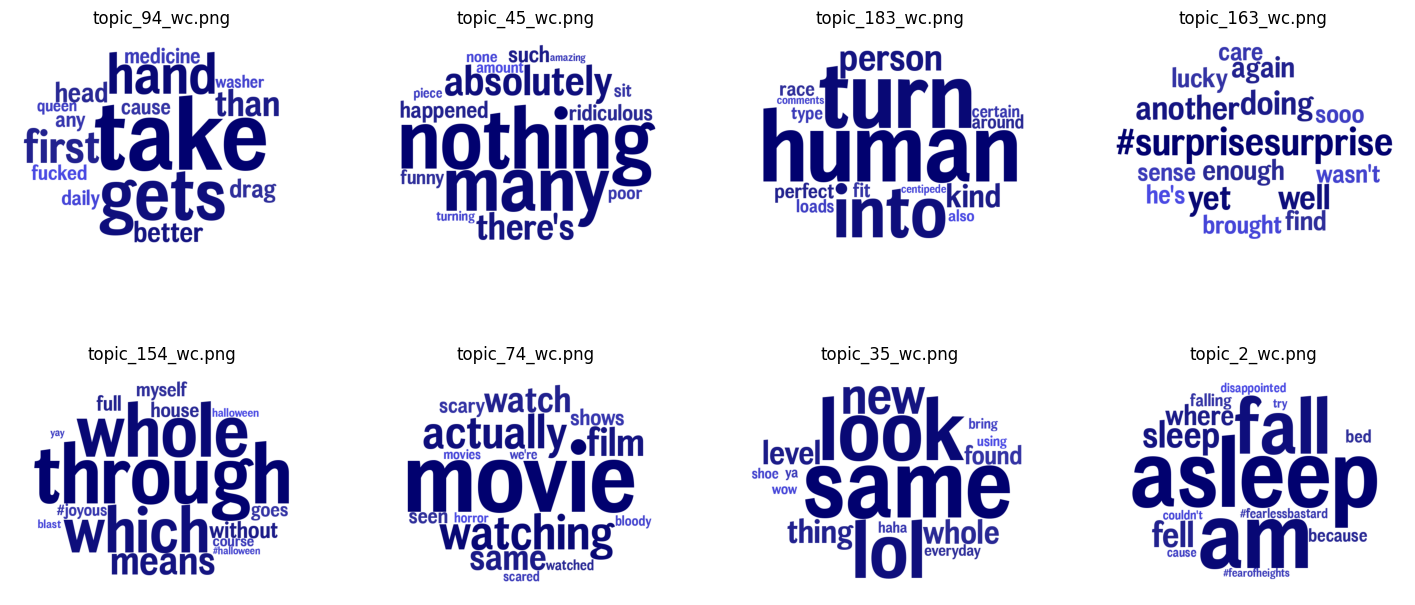

In [ ]:
WORDCLOUD_FOLDER = './output_tutorial_11/svitlana_topic_wordclouds_alltopics'
NUM_TOPICS = 8

print_topic_wordclouds(WORDCLOUD_FOLDER, NUM_TOPICS)

You would now be ready to extract these topics from another (or the same dataset), and correlate them, etc.

<h1> ⚠️

If you wanted to access these topics you've modeled, make sure to point to them with `--lexicondb svitlana`. In the feature extraction, you would use `--add_lexicon -l svitlana_200_a5s120_cp`, during the correlation of the resulting feature table with an outcome you would also add `--topic_lexicon svitlana_200_a5s120_freq_t50ll`.

If you wish, you could now correlate these topics with the annotation outcomes in the Svitlana database.

## ‼️ **Save your database and/or output files** ‼️

Let's save all this work into as a new database file in your GDrive `sqlite_databases` folder!

First **`dla_tutorial`**!

In [ ]:
database = 'dla_tutorial'

In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# copy the database file to your Drive
!cp -f "sqlite_data/{database}.db" "/content/drive/MyDrive/sqlite_databases/"

print(f"✅ Database '{database}.db' has been copied to your Google Drive.")

Mounted at /content/drive
✅ Database 'dla_tutorial.db' has been copied to your Google Drive.


Second **`svitlana`**.

In [ ]:
database = 'svitlana'

In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# copy the database file to your Drive
!cp -f "sqlite_data/{database}.db" "/content/drive/MyDrive/sqlite_databases/"

print(f"✅ Database '{database}.db' has been copied to your Google Drive.")

Mounted at /content/drive
✅ Database 'svitlana.db' has been copied to your Google Drive.


We generated a lot of output in this tutorial! Here's how you can save it to your Drive if you want to!

In [ ]:
OUTPUT_FOLDER = './output_tutorial_11'

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Copy the database file to your Drive (-r makes it copy the folder and all files/folders inside)
!cp -f -r {OUTPUT_FOLDER} "/content/drive/MyDrive/"

print(f"✅ '{OUTPUT_FOLDER}' has been copied to your Google Drive.")

Mounted at /content/drive
✅ './output_tutorial_11' has been copied to your Google Drive.
